In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.0 MB/s 
     |████████████████████████████████| 376 kB 35.0 MB/s 
     |████████████████████████████████| 58 kB 7.7 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=8114e50c43362437b311228e9fadd89855be8e51ad1b8f527de13a7eeb036f39
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=e1469553093c6d390644eb7c68eba0afbe9d98078cedf738f1dcf6497b4913eb
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm
import segmentation_models_pytorch as smp

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [5]:
# 자신의 폴더 경로에 맞게 재지정해주세요.
root_path_train = '/content/drive/MyDrive/Colab Notebooks/dataset/train'
root_path_val = '/content/drive/MyDrive/Colab Notebooks/dataset/val'
root_path_test = '/content/drive/MyDrive/Colab Notebooks/dataset/test'

train_dir = root_path_train
val_dir = root_path_val
test_dir = root_path_test

# data_dir의 경로(문자열)와 train(문자열)을 결합해서 train_dir(train 폴더의 경로)에 저장합니다.
train_dir_data = os.path.join(train_dir, "data")
train_dir_label = os.path.join(train_dir, "label")

# data_dir의 경로(문자열)와 val(문자열)을 결합해서 val_dir(val 폴더의 경로)에 저장합니다.
val_dir_data = os.path.join(val_dir, "data")
val_dir_label = os.path.join(val_dir, "label")

test_dir_data = os.path.join(test_dir, "data")
test_dir_label = os.path.join(test_dir, "label")

# train_dir 경로에 있는 모든 파일을 리스트의 형태로 불러와서 train_fns에 저장합니다.
# train_fns_data = os.listdir(train_dir_data)
# train_fns_label = os.listdir(train_dir_label)

# val_dir 경로에 있는 모든 파일을 리스트의 형태로 불러와서 val_fns에 저장합니다.
# val_fns = os.listdir(val_dir)

# print(len(train_fns_data), len(train_fns_label))

In [6]:
num_items = 1000

# 0~255 사이의 숫자를 3*num_items번 랜덤하게 뽑기
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 1)
print(color_array.shape)

(3000, 1)


In [7]:
num_classes = 2

# K-means clustering 알고리즘을 사용하여 label_model에 저장합니다.
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=2)

In [8]:
class CP2Dataset(Dataset):

  def __init__(self, data_dir, label_dir, label_model):
    self.data_dir = data_dir
    self.label_dir = label_dir
    self.data_fns = sorted(os.listdir(data_dir))
    self.label_fns = sorted(os.listdir(label_dir))
    self.label_model = label_model
    
  def __len__(self) :
    return len(self.data_fns)
    
  def __getitem__(self, index) :
    data_fn = self.data_fns[index]
    data_fp = os.path.join(self.data_dir, data_fn)
    image_data = Image.open(data_fp)
    # data = np.array(image_data)
    label_fn = self.label_fns[index]
    label_fp = os.path.join(self.label_dir, label_fn)
    image_label = Image.open(label_fp)
    # label = np.array(image_label)

    label = self.transform_label(image_label)
    label = np.array(label)
    label_class = label / 255
    # label_class = self.label_model.predict(label.reshape(-1, 1)).reshape(256, 256)
    # label_class = 1 - label_class
    label_class = torch.Tensor(label_class).long()
    data = self.transform_data(image_data)
    return data, label_class
    
  def transform_data(self, image) :
    transform_ops = transforms.Compose([
            transforms.Resize((256, 256)),
      			transforms.ToTensor(),
            transforms.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

  def transform_label(self, image):
    transform_ops = transforms.Compose([
            transforms.Resize((256, 256))
    ])
    return transform_ops(image)

In [9]:
dataset = CP2Dataset(train_dir_data, train_dir_label, label_model)
print(len(dataset))

data, label_class = dataset[0]
print(data.shape)
print(label_class.shape)
dataset[1]

3012
torch.Size([3, 256, 256])
torch.Size([256, 256])


(tensor([[[-0.0801, -0.0801, -0.0801,  ..., -1.5870, -1.5528, -1.5528],
          [-0.0801, -0.0629, -0.0458,  ..., -1.4843, -1.5185, -1.5357],
          [-0.0287, -0.0287, -0.0116,  ..., -1.5528, -1.5870, -1.6213],
          ...,
          [ 0.9988,  0.9988,  0.9817,  ..., -0.0801, -0.0801, -0.0629],
          [ 0.9646,  0.9646,  0.9646,  ..., -0.0801, -0.0801, -0.0629],
          [ 0.9474,  0.9474,  0.9474,  ..., -0.0801, -0.0801, -0.0629]],
 
         [[ 0.1436,  0.1436,  0.1436,  ..., -1.9223, -1.9223, -1.9048],
          [ 0.1436,  0.1611,  0.1786,  ..., -1.8172, -1.8347, -1.8522],
          [ 0.1961,  0.1961,  0.2136,  ..., -1.7822, -1.7997, -1.8172],
          ...,
          [-0.6618, -0.6618, -0.6793,  ..., -1.9748, -1.9748, -1.9573],
          [-0.6968, -0.6968, -0.6968,  ..., -1.9748, -1.9748, -1.9573],
          [-0.7143, -0.7143, -0.7143,  ..., -1.9748, -1.9748, -1.9573]],
 
         [[ 0.8099,  0.8099,  0.8099,  ..., -1.0724, -1.0898, -1.0898],
          [ 0.8099,  0.8274,

In [10]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [11]:
batch_size = 2
epochs = 90
lr = 0.001

train_dataset = CP2Dataset(train_dir_data, train_dir_label, label_model)
train_loader = DataLoader(train_dataset, batch_size = batch_size)

val_dataset = CP2Dataset(val_dir_data, val_dir_label, label_model)
val_loader = DataLoader(val_dataset, batch_size = 1)

model = UNet(num_classes = num_classes).to(device)

loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([
  dict(params=model.parameters(), lr=lr)
])
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                                              lr_lambda=lambda epoch: 0.95 ** epoch,
                                              last_epoch=-1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [12]:
train_epoch = smp.utils.train.TrainEpoch(
  model,
  loss=loss,
  metrics=metrics,
  optimizer=optimizer,
  device=device,
  verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
  model,
  loss=loss,
  metrics=metrics,
  device=device,
  verbose=True,
)

In [13]:
for i in range(0, epochs):
  print(f'\nEpoch: {i}')
  train_logs = train_epoch.run(train_loader)
  valid_logs = valid_epoch.run(val_loader)


Epoch: 0
valid: 100%|██████████| 108/108 [01:58<00:00,  1.10s/it, dice_loss - 0.9972, iou_score - 0.01004]

Epoch: 1
valid: 100%|██████████| 108/108 [00:18<00:00,  5.73it/s, dice_loss - 0.9983, iou_score - 0.01007]

Epoch: 2
valid: 100%|██████████| 108/108 [00:20<00:00,  5.37it/s, dice_loss - 0.8031, iou_score - 0.01246]

Epoch: 3
valid: 100%|██████████| 108/108 [00:19<00:00,  5.58it/s, dice_loss - 0.991, iou_score - 0.01036]

Epoch: 4
valid: 100%|██████████| 108/108 [00:18<00:00,  5.69it/s, dice_loss - 0.9533, iou_score - 0.01427]

Epoch: 5
valid: 100%|██████████| 108/108 [00:18<00:00,  5.72it/s, dice_loss - 0.9757, iou_score - 0.009005]

Epoch: 6
valid: 100%|██████████| 108/108 [00:19<00:00,  5.59it/s, dice_loss - 0.9613, iou_score - 0.007527]

Epoch: 7
valid: 100%|██████████| 108/108 [00:20<00:00,  5.32it/s, dice_loss - 0.2563, iou_score - 0.006888]

Epoch: 8
valid: 100%|██████████| 108/108 [00:19<00:00,  5.63it/s, dice_loss - 0.9456, iou_score - 0.007198]

Epoch: 9
valid: 100%|███

In [14]:
test_dataset = CP2Dataset(test_dir_data, test_dir_label, label_model)
test_loader = DataLoader(test_dataset, batch_size = 1)
test_logs = valid_epoch.run(test_loader)

valid: 100%|██████████| 17/17 [00:16<00:00,  1.01it/s, dice_loss - 0.9957, iou_score - 0.002479]


In [15]:
model_name = "UNet_v3.pth"
torch.save(model.state_dict(), model_name)

In [16]:
from google.colab import files
files.download(model_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# model = UNet(num_classes = num_classes).to(device)
# model.load_state_dict(torch.load("UNet_v3.pth"))

In [18]:
val_batch_size = 20
val_dataset = CP2Dataset(val_dir_data, val_dir_label, label_model)
val_loader = DataLoader(val_dataset, batch_size = val_batch_size)

iter_loader = iter(val_loader)

In [19]:
X,Y = next(iter_loader)
X,Y = X.to(device), Y.to(device)
Y_pred = model(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([20, 2, 256, 256])
torch.Size([20, 256, 256])


In [20]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

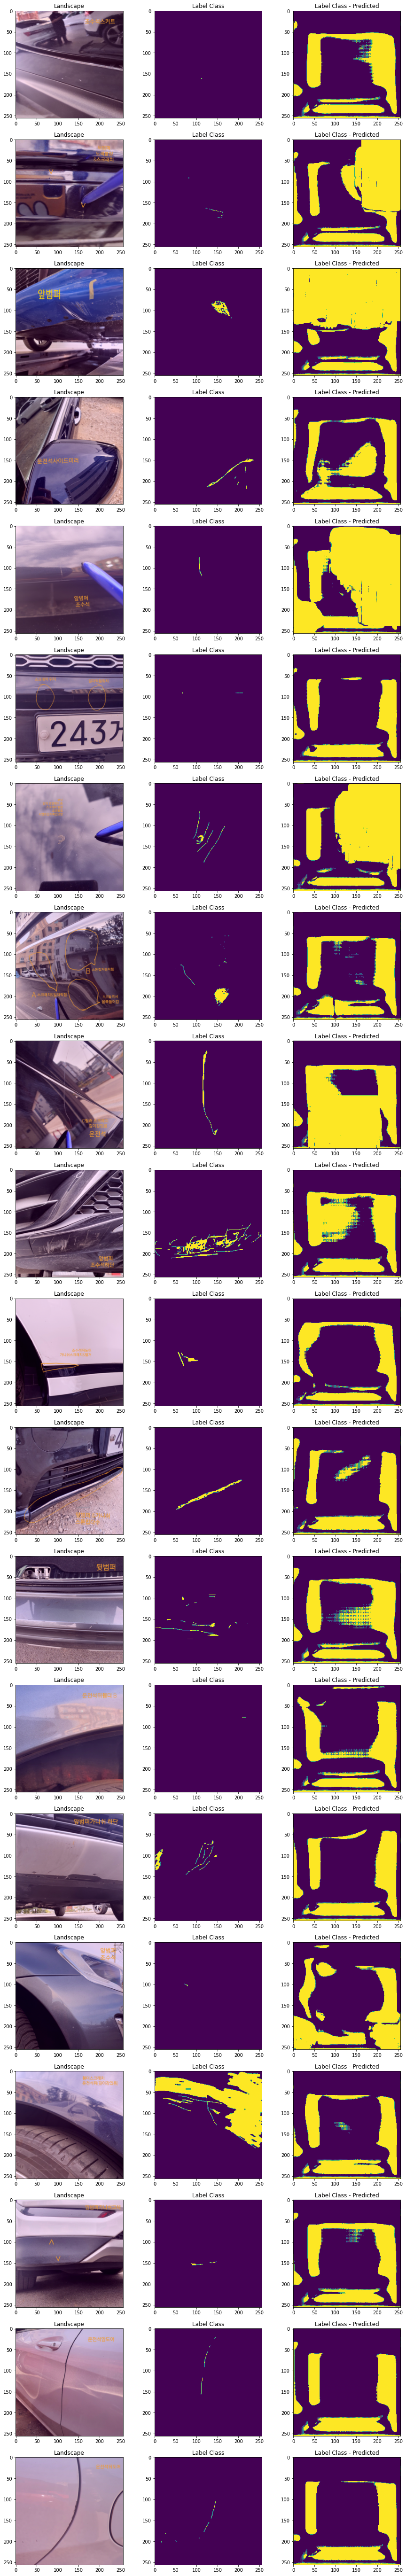

In [21]:
fig, axes = plt.subplots(val_batch_size, 3, figsize=(3*5, val_batch_size*5))

iou_scores = []

for i in range(val_batch_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

plt.show()

In [22]:
print(sum(iou_scores) / len(iou_scores))